## MY CNN model

Test CNN model

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
BATCH_SIZE = 32
# IMG_SIZE = (500,500)
# IMG_W = 500
# IMG_H = 500
IMG_SIZE = (40,40)
IMG_W = 40
IMG_H = 40
# IMG_SIZE = (200,200)
# IMG_W = 200
# IMG_H = 200

In [4]:
train_dataset = image_dataset_from_directory("../dataset/train/",
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 7818 files belonging to 10 classes.


In [5]:
validation_dataset = image_dataset_from_directory("../dataset/test/",
                                                 shuffle=True,
                                                 batch_size=BATCH_SIZE,
                                                 image_size=IMG_SIZE)

Found 3806 files belonging to 10 classes.


In [6]:
class_names = train_dataset.class_names
class_names

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

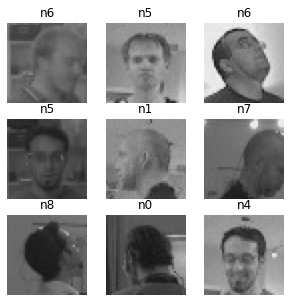

In [16]:
plt.figure(figsize=(5,5))
for images, labels in train_dataset.take(1):
    first_image=images[0]
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [17]:
first_image.shape

TensorShape([40, 40, 3])

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches//5)
validation_dataset = validation_dataset.skip(val_batches//5)

In [9]:
print("Number of validation batches : %d" %tf.data.experimental.cardinality(validation_dataset))
print("Number of test batches : %d" %tf.data.experimental.cardinality(test_dataset))

Number of validation batches : 96
Number of test batches : 23


In [10]:
AUTOTUNE =tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout

In [12]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset = -1)

In [14]:
#### Ucohead original

# model = Sequential()

# model.add(Conv2D(22, kernel_size=(3,3), 
#                  strides=2,
#                 activation='relu',
#                 input_shape=(img_rows, img_cols,1)))
# model.add(Dropout(0.5))
# model.add(Conv2D(22, kernel_size=(3,3), 
# #                       strides=2, 
#                      activation='relu'))  

# # add for check(11/19)
# # model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.5))
# ### added for check (11/19)
# # model.add(Conv2D(22, kernel_size=(3,3), strides=2, activation='relu'))  
# # model.add(Dropout(0.5))

# model.add(Flatten())
# # model.add(Dense(22, activation='relu'))
# model.add(Dense(32, activation='relu'))  # tested 256, 128, 64, 32

# ### added for check (11/19)
# # model.add(Dense(22, activation='relu'))

# model.add(Dense(num_classes, activation='softmax'))
# model.compile(loss=keras.losses.categorical_crossentropy, 
#               optimizer='adam', metrics=['accuracy'])

def my_model(input_shape, drop_rate): # dr0.2/
    model = Sequential([
        Conv2D(filters=22, input_shape=input_shape, kernel_size=(3,3), strides=2, activation = 'relu'),
        Dropout(drop_rate),
        Conv2D(filters=22, kernel_size=(3,3), activation='relu'),
        Dropout(drop_rate),
        Dense(units=32, activation='relu')
#         Dense(units=1, activation='softmax')
    ])
    return model

In [86]:
# # ##### ref01
# def my_model(input_shape, drop_rate): # dr0.2/
#     model = Sequential([
#         Conv2D(filters=32, input_shape=input_shape, kernel_size=(3,3), activation = 'relu'),
#         MaxPooling2D(pool_size=(2,2)),
#         Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
#         MaxPooling2D(pool_size=(2,2)),
#         Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
#         MaxPooling2D(pool_size=(2,2)),
#         Dropout(drop_rate),
#         Flatten(),
#         Dropout(drop_rate),
#         Dense(units=256, activation='relu'),
#         Dropout(drop_rate),
#         Dense(units=256, activation='relu')
# #         Dense(units=1, activation='softmax')
#     ])
#     return model

In [18]:
drop_rate = 0.5 #looks it works better than 0.5

model = my_model(first_image.shape, drop_rate)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 19, 19, 22)        616       
_________________________________________________________________
dropout (Dropout)            (None, 19, 19, 22)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 22)        4378      
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 17, 22)        0         
_________________________________________________________________
dense (Dense)                (None, 17, 17, 32)        736       
Total params: 5,730
Trainable params: 5,730
Non-trainable params: 0
_________________________________________________________________


In [20]:
prediction_layer = tf.keras.layers.Dense(10, activation="softmax")  
#default -linear, 0.5375
#softmax, 0.4000
#relu, 0.6250

In [21]:
inputs = tf.keras.Input(shape=(IMG_W, IMG_H, 3))
# x = data_augmentation(inputs)
x = inputs
x = rescale(x)
x = model(x)
outputs = prediction_layer(x)
cnn_model = tf.keras.Model(inputs, outputs)

In [29]:
base_lr = 0.0001
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_lr), 
#                   loss = tf.keras.losses.categorical_crossentropy(from_logits=True),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [30]:
cnn_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 3)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 40, 40, 3)         0         
_________________________________________________________________
sequential (Sequential)      (None, 17, 17, 32)        5730      
_________________________________________________________________
dense_1 (Dense)              (None, 17, 17, 10)        330       
Total params: 6,060
Trainable params: 6,060
Non-trainable params: 0
_________________________________________________________________


In [31]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

class TrainingCallback(Callback):
    def on_train_begin(self, logs=None):
        print("Starting training ...")
    def on_train_end(self, logs=None):
        print("Finished training!")

early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)

In [32]:
initial_epochs = 200
loss0, accuracy0 = cnn_model.evaluate(validation_dataset)

InvalidArgumentError:  Incompatible shapes: [32,17,17] vs. [32,1]
	 [[node Equal (defined at <ipython-input-32-1dca4ce13127>:2) ]] [Op:__inference_test_function_1347]

Function call stack:
test_function


In [96]:
print("initial loss : {:.2f}".format(loss0))
print("initial accuracy : {:.2f}".format(accuracy0))

initial loss : 0.69
initial accuracy : 0.61


In [27]:
# history = cnn_model.fit(train_dataset,
#                        epochs=initial_epochs,
#                        validation_data=validation_dataset,
#                        callbacks=[TrainingCallback(), early_stopping])
history = cnn_model.fit(train_dataset,
                       epochs=initial_epochs,
                       validation_data=validation_dataset,
                       callbacks=[TrainingCallback()])

Starting training ...
Epoch 1/200


ValueError: in user code:

    /home/lee/anaconda3/envs/cell/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/lee/anaconda3/envs/cell/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/lee/anaconda3/envs/cell/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/lee/anaconda3/envs/cell/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/lee/anaconda3/envs/cell/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/lee/anaconda3/envs/cell/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/lee/anaconda3/envs/cell/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /home/lee/anaconda3/envs/cell/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/lee/anaconda3/envs/cell/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /home/lee/anaconda3/envs/cell/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/lee/anaconda3/envs/cell/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/lee/anaconda3/envs/cell/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /home/lee/anaconda3/envs/cell/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/lee/anaconda3/envs/cell/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/lee/anaconda3/envs/cell/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 17, 17, 10) are incompatible


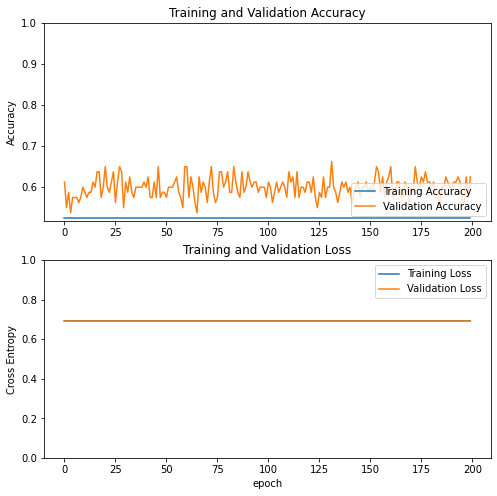

In [98]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [334]:
# import pickle
# with open("./cnn_model_test00",'wb') as file_pi:
#     pickle.dump(history_fine.history, file_pi)

In [335]:
# test_load = pickle.load(open("./cnn_model_test00",'rb'))
# test_load['loss']